In [ ]:
import cv2
import glob
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset,DataLoader
from torchvision import datasets, transforms

In [ ]:
! pip install torchsummary
from torchsummary import summary

In [ ]:
!unzip '/content/bones.zip'

Archive:  /content/bones.zip
  inflating: Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0.jpg  
  inflating: Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/05cc2e0302957e0ad27edb6b9ffbc2_jumbo_jpg.rf.c15eb3758845b639f3aaba73c373501d.jpg  
  inflating: Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/1-s2-0-S0899707114002836-gr2_jpg.rf.bb8ed4dee892edbb760f6ce687d74ba5.jpg  
  inflating: Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/13256_2019_2325_Fig1_HTML_png.rf.09368fddb2da3979a35a0cac6f45.jpg  
  inflating: Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/13256_2019_2325_Fig1_HTML_png.rf.09368fddb2da3979a3e1e25a0cac6f45.jpg  
  inflating: Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/1b62e6fbfbc5a2f70c6af413189cfc82_jpg.rf.2761e933cc6d206308877cccaf0642b2.jpg  
  inflating: 

In [ ]:
def accuracy(true, pred):
  pred = torch.max(pred, 1)[1]
  truth  = torch.max(true, 1)[1]
  acc = (pred == truth).sum()
  return acc

In [ ]:
class BoneDataset(Dataset):

  def __init__(self, img_path,train_test):
    self.data =[]
    self.class_map = {}
    self.img_dim = (220, 220)
    folders = glob.glob(img_path + "*/", recursive = True)
    i = 0
    for folder in folders:
      label = folder.split('/')[-2]
      file_list = glob.glob(folder + train_test+'/'+'*.jpg',recursive=True)
      for img_path in file_list:
        self.data.append([img_path, label])
      self.class_map[label] = i
      i = i +1

  def __len__(self):
    # this should return the size of the dataset
    return len(self.data)

  def __getitem__(self, idx):
    # this should return one sample from the dataset
    img_path, label = self.data[idx]
    img = cv2.imread(img_path)
    img = cv2.resize(img, self.img_dim)
    label_id = self.class_map[label]
    img_tensor = torch.from_numpy(img)
    img_tensor = img_tensor.permute(2,0,1)
    label_id = torch.nn.functional.one_hot(torch.tensor(label_id), num_classes=10)


    return img_tensor, label_id

In [ ]:
img_path = '/content/Bone Break Classification/Bone Break Classification/'
batch_size = 32
train_dataset = BoneDataset(img_path,train_test='Train')
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BoneDataset(img_path,train_test='Test')
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_dataset), len(test_dataset)

(989, 140)

In [ ]:
pretrained_model = models.resnet18(pretrained=True)

In [ ]:
summary(pretrained_model,(3,220,220))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 110, 110]           9,408
       BatchNorm2d-2         [-1, 64, 110, 110]             128
              ReLU-3         [-1, 64, 110, 110]               0
         MaxPool2d-4           [-1, 64, 55, 55]               0
            Conv2d-5           [-1, 64, 55, 55]          36,864
       BatchNorm2d-6           [-1, 64, 55, 55]             128
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]          36,864
       BatchNorm2d-9           [-1, 64, 55, 55]             128
             ReLU-10           [-1, 64, 55, 55]               0
       BasicBlock-11           [-1, 64, 55, 55]               0
           Conv2d-12           [-1, 64, 55, 55]          36,864
      BatchNorm2d-13           [-1, 64, 55, 55]             128
             ReLU-14           [-1, 64,

In [ ]:
for param in pretrained_model.parameters():
    param.requires_grad = False

num_classes= 10
num_ftrs = pretrained_model.fc.in_features
# Adding extra fully connected layers
pretrained_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
summary(pretrained_model,(3,220,220))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 110, 110]           9,408
       BatchNorm2d-2         [-1, 64, 110, 110]             128
              ReLU-3         [-1, 64, 110, 110]               0
         MaxPool2d-4           [-1, 64, 55, 55]               0
            Conv2d-5           [-1, 64, 55, 55]          36,864
       BatchNorm2d-6           [-1, 64, 55, 55]             128
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]          36,864
       BatchNorm2d-9           [-1, 64, 55, 55]             128
             ReLU-10           [-1, 64, 55, 55]               0
       BasicBlock-11           [-1, 64, 55, 55]               0
           Conv2d-12           [-1, 64, 55, 55]          36,864
      BatchNorm2d-13           [-1, 64, 55, 55]             128
             ReLU-14           [-1, 64,

In [ ]:
num_epochs = 10
train_loss =[]
test_loss = []
train_accuracy=[]
test_accuracy=[]
for epoch in range(num_epochs):
  train_running_loss = 0.0
  train_acc = 0
  train_samples = 0

  test_running_loss = 0.0
  test_acc = 0
  test_samples = 0
  for inputs, labels in train_data_loader:
    optimizer.zero_grad()

    predicted = pretrained_model(inputs.float())

    labels =  labels.to(torch.float)
    loss = criterion(predicted, labels)
    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
    train_acc = train_acc + accuracy(labels, predicted)
    train_samples = train_samples+len(inputs)

  train_loss.append(train_running_loss/len(inputs))
  train_accuracy.append(train_acc/train_samples)

  for test_inp, test_label in test_data_loader:
    test_predicted = pretrained_model(test_inp.float())

    test_label =  test_label.to(torch.float)
    loss = criterion(test_predicted, test_label)

    test_running_loss += loss.item()
    test_acc = test_acc + accuracy(test_label, test_predicted)
    test_samples = test_samples+len(test_inp)

  test_loss.append(test_running_loss/len(test_inp))
  test_accuracy.append(test_acc/test_samples)
  print(f"Epoch {epoch} done")

Epoch 0 done
Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 done
Epoch 7 done
Epoch 8 done
Epoch 9 done


In [ ]:
# Optionally, save the model
torch.save(pretrained_model.state_dict(), 'fine_tuned_model.pth')

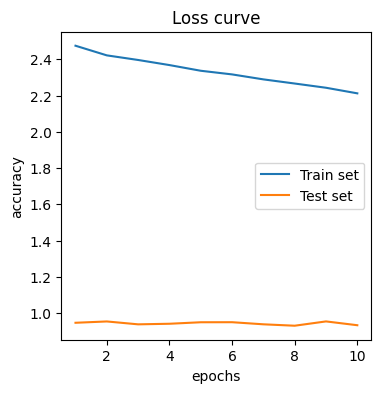

In [ ]:
import numpy as np
x = np.arange(1,11)  # X-axis points
plt.figure(figsize=(4,4))
plt.plot(x,train_loss,label='Train set')
plt.plot(x, test_loss, label='Test set')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Loss curve")
plt.legend()
plt.show()

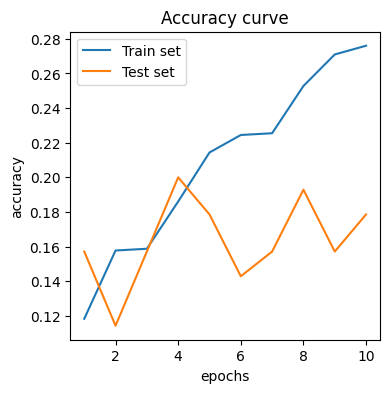

In [ ]:
import numpy as np
x = np.arange(1,11)  # X-axis points
plt.figure(figsize=(4,4))
plt.plot(x,train_accuracy,label='Train set')
plt.plot(x, test_accuracy, label='Test set')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy curve")
plt.legend()
plt.show()

In [ ]:
truth_labels = []
for x , y in test_data_loader:
  truth_labels.extend(torch.max(y, 1)[1].tolist())

In [ ]:
predictions = []
for x , y in test_data_loader:
  preds = pretrained_model(x.float())
  predictions.extend(torch.max(preds, 1)[1].tolist())

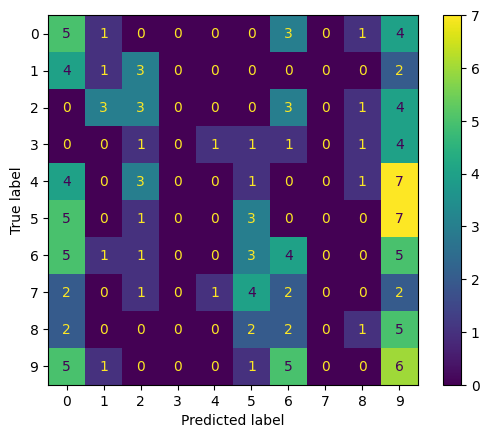

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(truth_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              )
disp.plot()
plt.show()